# Machine Learning in Python - Project 2

Alfie Plant, Markus Emmott, Oscar Youngman, Ashe Raymond-Barker

## Setup

*Install any packages here, define any functions if neeed, and load data*

In [26]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay

# EDA plotter functions
from helper import *

from imblearn.over_sampling import RandomOverSampler, SMOTE

# Introduction

Brief discussion of problem and approaches used

### Data Overview

The dataset consists of 200,000 fully amortizing fixed-rate Single-Family mortgages. Of these, 125,959 have been paid off, 73,295 are still active, and 746 have defaulted. There are $32$ features, which can be categorised as follows:

 - **Personal Details:**
    - **fico** (Numeric): Borrower's credit score
    - **dti** (Numeric): Ratio value of borrower(s) monthly debt payments to total monthly income
    - **cnt_borr** (Categorical): Whether one of multiple borrowers are obligated to pay the mortgage: One borrower (1), Multiple borrowers (2)
    - **cltv** (Numeric): Ratio value of all combined loans of Borrower(s) to value of property
    - **ltv** (Numeric): Ratio value of mortgage loan of Borrower(s) to value of property
  
- **Loan Details:**
    - **dt_first_pi** (Numeric): First payment date of mortgage (YYYYMM)
    - **dt_matr** (Numeric): Final payment date of mortgage (YYYYMM)
    - **mi_pct** (Numeric): Percentage of loss coverage on the loan insurance plan, where 0 indicates no insurance
    - **orig_upb** (Numeric): Unpaid balance of mortgage to the nearest $1,000
    - **int_rt** (Numeric): Interest rate of loan
    - **channel** (Categorical): Indicates whether Broker or correspondent was involved in origination of mortgage loan: Retail(R), Broker(B), Correspondent(C)
    -  **loan_purpose** (Categorical): Indicates type of loan: Chash-out refinance mortgage(C), No cash-out refinance mortgage(N), Purchase mortgage(P)
    - **orig_loan_term** (Numeric): Number of scheduled monthly repayments on mortgage
    - **prod_type** (Categorical): Denotes whether mortgage is fixed rate or adjustable rate
    - **seller_name** (Categorical): Entity acting as seller of mortgages to Freddie Mac
    - **servicer_name** (Categorical): Entity acting as servicer of mortgages to Freddie Mac
    - **flag_sc** (Categorical): Indicates whether mortgages with origination dates after 10/1/2008, delived to Freddie Mac on or after 1/1/2009 exceed the conforming loan limits
    - **program_ind** (Categorical): Indicates whether loan is part of any programmes: Home Possible(H), HFA Advantage(F), Refi Possible(R) Not Available/Applicable(9)
    - **rr_ind** (Categorical): Indicates whether loan is part of Relief Refinance Program.
    - **io_ind** (Categorical): Indicates whether loan only requires interest payments for a specific period
    - **mi_cancel_ind** (Categorical): Indicates whether mortgage insurance has been reported as cancelled after time of Freddie Macs purchase of the mortgage loan: Cancelled(Y), Not Cancelled(N), Not Applicable(7), Not Disclosed(9)
    - **loan_status** (Categorical): Indicates whether borrower(s) has defaulted on loan, paid off loan or if loan is still active
  
- **Property Details:**
    - **flag_fthb** (Categorical): Indicates whether Borrower(s) is a purchasing mortgaged property as a primary residence, having had no ownership interest in a residential property in the three years prior: Yes(Y), No(N), Not available/applicable(9)
    - **cd_msa** (Categorical): Metropolitan Statistical Area (MSA) or Metropolitan Division
    - **cnt_units** (Ordinal)/(Categorical) Denotes number of units in property: One(1), Two(2), Three(3), Four(4), Not available(99)
    - **occpy_sts** (Categorical): Indicates status of property: Owner occupied(P), Second home(S), Investment property(I), Not available (9)
    - **st** (Categorical): Indicates State to which property belongs
    - **prop_type** (Categorical): Denotes property type: Condominium(CO), Planned unit development(PU), Cooperative share(CP), Manufactured home(MH), Single-family home(SF)
    - **zipcode** (Categorical): Postal code for location of mortgaged property
    - **property_val** (Categorical): Indicates method used to obtain property appraisal, if any: ACE Loans(1), Full Appraisal(2), Other Appraisals(3), ACE+PDR(4), Not Available(9)

The following columns from the data set have been removed since they do not offer any additional information:
- **ppmt_pnlty**, **io_ind** and **prod_type** are categorical features that only contain one value
- **id_loan_rr** can be removed since it is an indicator that is also given by **rr_ind**.
- **id_loan** ***we could keep this if we want to consider a comparison of the origination date and the first payment date***

In [14]:
d = pd.read_csv("freddiemac_extra2.csv", low_memory=False)
d = d.drop(columns=['id_loan', 'id_loan_rr', 'io_ind', 'prod_type', 'ppmt_pnlty'])


### Missing Data

The data includes approximately 20,000 null values for the **cd_msa** information. Despite this, there is no missing information on **zipcode**. As a result, we have decided to use zipcode data in analysis. This will be discussed in more detail in exploratory data analysis.
The remaining features that contain null values are **flag_sc**, and **rr_ind**, however these are categorical variables that take NaN to refer to 'No'. All NaN entries have been replaced with 'N'.

There are 41 missing Credit Scores in the dataset. Out of these, 3 loans were defaults. Since the dataset does not contain many defaults, we do not want to exclude this information and we will proceed by ***add detail here...***. Only one observation is not available for the mortgage insurance percentage and given this loan was not a default, we will exclude it from the data set. There are 6 missing observations for combined loan-to-value, and 2 of these are the missing values for loan-to-value, which occurs when the loanee has no other loans. None of these loans were defaults, so they have been excluded.

There are 2,412 missing values for the debt-to-income ratio, and more notably, a disproportinal number of these observations are loans that have defaulted. When debt-to-income ratio is greater than 65%, it is classified as a missing value. These are loans where the monthly debt payments are greater than 65% of monthly income of the loanee suggesting that they are higher-risk loans. To deal with this we have discretised debt-to-income and encoded it ordinally. We have used cross-validation to determine a reasonable choice for the number of bins as 10.

We interpret the value of 9 for the program indicator as Not Applicable meaning that the loan is not part of a program. There could be missing data embedded within this, however since this category acts as a baseline associated to no programs, then this assumption does not lose any information. Finally, there are 125 values missing for property value. None of these are defaults, so they have been excluded.

In [10]:
d['flag_sc'] = d['flag_sc'].fillna('N')
d['rr_ind'] = d['rr_ind'].fillna('N')
d = d[d['fico'] != 9999] # removed missing credit scores for now but perhaps we should reconsider
d = d[d['mi_pct'] != 999]
d = d[d['cltv'] != 999]
d = d[d['property_val'] != 9]

### Data Split

***To avoid any data leakage, the dataset is split into training and test sets from this point onwards.***

We will separate active loans from non-active loans. The non-active loans will be separated a training set (70%) to build the model, a validation set to tune the model (15%), and finally a test set (15%). Once the final model has been determined, it will be used to offer insight on existing loans with Freddie Mac.

In [23]:
active = d[d['loan_status'] == 'active']
nonactive = d[d['loan_status'] != 'active']
nonactive = d[[col for col in d.columns if col != 'loan_status'] + ['loan_status']]

# Feature matrix and response vector
X, y = nonactive.drop(['loan_status'], axis=1), nonactive['loan_status']

# Convert to numpy array
X = X.values

# Encode default
y = LabelEncoder().fit_transform(y)

# Naively split the data into train and test sets 
X_train, X_tv, y_train, y_tv = train_test_split(X, y, shuffle= True,
                                                    test_size = 0.3, random_state=1112, stratify=y)

X_test, X_val, y_test, y_val = train_test_split(X_tv, y_tv, shuffle= True,
                                                    test_size = 0.5, random_state=1112, stratify=y_tv)

# Convert back to DataFrame
df_train = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1), columns=nonactive.columns)
df_test = pd.DataFrame(np.concatenate([X_test, y_test.reshape(-1, 1)], axis=1), columns=nonactive.columns)
df_val = pd.DataFrame(np.concatenate([X_test, y_test.reshape(-1, 1)], axis=1), columns=nonactive.columns)

# np.unique(y_train, return_counts=True)

# df_train.columns
nonactive.columns

Index(['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr', 'cd_msa', 'mi_pct',
       'cnt_units', 'occpy_sts', 'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt',
       'channel', 'st', 'prop_type', 'zipcode', 'loan_purpose',
       'orig_loan_term', 'cnt_borr', 'seller_name', 'servicer_name', 'flag_sc',
       'program_ind', 'rr_ind', 'property_val', 'mi_cancel_ind', 'zip', 'lng',
       'lat', 'county_fips', 'loan_status'],
      dtype='object')

# Exploratory Data Analysis

### Categorical Data

{1: 97.4, 2: 1.8, 3: 0.5, 4: 0.3}


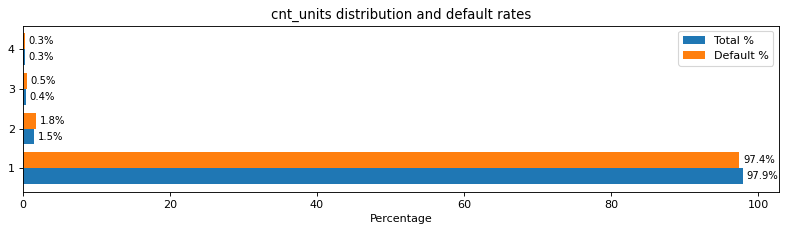

In [24]:

plot_categorical(df_train, 'cnt_units')

### Numerical Data

### Geographical Data

In [ ]:
# Column Transformer Pipeline

dti_index = df_train.columns.get_loc("dti")
num_var = ["fico","dt_first_pi","mi_pct","orig_upb","int_rt","dt_matr","cltv", "ltv", "orig_loan_term", "lat", "long"]
cat_var = ["seller_name", "servicer_name","flag_fthb", "cnt_units", "occpy_sts", "channel", "prop_type", "loan_purpose", "cnt_borr", "flag_sc", "program_ind", "rr_ind", "property_val", "mi_cancel_ind"]

num_var_index = df_train.columns.get_indexer(num_var)
cat_var_index = df_train.columns.get_indexer(cat_var)

ct = Pipeline(
    [("pre_processing", ColumnTransformer(
        [("disc", KBinsDiscretizer(encode='ordinal', n_bins=10), [dti_index]),
         ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), cat_var_index),
         ("num", StandardScaler(), num_var_index)]
    ))])

ct.fit(X_train)
X_train_e = ct.transform(X_train)


In [33]:
# Dealing with Imbalance

OS = RandomOverSampler(random_state=1112)
X_train_e_over, y_train_over = OS.fit_resample(X_train_e, y_train)

SMTE = SMOTE(random_state=1112)
X_train_e_smote, y_train_smote = SMTE.fit_resample(X_train_e, y_train)

# Model Fitting and Tuning

### Logistic Regression

Comment on excluding Linear SVM due to poor performance of LogReg

### Non-Linear SVM

Try sparse input to deal with training time. If not, consider bagging. Experiment with poly, rbf, sigmoid, cosine and fine tune parameters.
Adapt loss function in GridSearch

### Random Forests
Look through Ashe's work and integrate.
Feature Importance

### Neural Networks



### Final Model
Discussion and Results of final choices

### Active Loans
Bank rating
Heatmap of location risk



# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, estimated parameters and relationships, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a banking official, who is understands the issues associated with mortgage defaults but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also discuss potential limitations or directions of future improvement of your model.*

*Finally, you should include recommendations on factors that may increase the risk of default, which may be useful for the companies to improve their understanding of
mortgage defaults, and also to explain their decisions to clients and regulatory bodies. You should also use your model to inform the company of any active loans that are at risk of default.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# Generative AI statement

*Include a statement on how generative AI was used in the project and report.*

# References

*Include references if any*

In [7]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] Writing 46841 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 72312 bytes to project2.pdf
